# **Introduction**

The garment industry refers to the production and distribution of clothing and related accessories, which also includes the textile sector that creates fibers and fabrics. As a significant part of the global manufacturing landscape, the garment industry employs millions of people and contributes trillions of dollars to the economy. Given its scale, maximizing workforce productivity is essential for the industry's success. This project focuses on estimating the productivity score for each team in a garment factory by analyzing a dataset related to worker productivity using an Artificial Neural Network (ANN) model in deep learning. ANN is particularly effective at identifying complex patterns within data, allowing us to pinpoint key factors that influence productivity scores. Through systematic data collection, preprocessing, model development, and evaluation, we aim to derive valuable insights that can improve efficiency and assist in strategic decision-making within the garment industry.

In [4]:
# Import Library
import keras_tuner as kt

import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler,LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from warnings import filterwarnings
filterwarnings('ignore')

SEED_VALUE=1234
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

ModuleNotFoundError: No module named 'keras_tuner'

In [ ]:
# Load Dataset
df = pd.read_parquet("dataset_1B.parquet")
df.head()

,date,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
0,1/1/2015,Quarter1,Thursday,8,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073
1,1/1/2015,Quarter1,Thursday,1,3.94,NaN,960,0,0.0,0,0,8.0,88.650
2,1/1/2015,Quarter1,Thursday,11,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
3,1/1/2015,Quarter1,Thursday,12,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
4,1/1/2015,Quarter1,Thursday,6,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038


# **Structure**

In [ ]:
# Shape of the dataset
df.shape

(1197, 13)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1197 non-null   object 
 1   quarter             1197 non-null   object 
 2   day                 1197 non-null   object 
 3   Team Code           1197 non-null   int64  
 4   smv                 1197 non-null   float64
 5   wip                 691 non-null    float64
 6   over_time           1197 non-null   int64  
 7   incentive           1197 non-null   int64  
 8   idle_time           1197 non-null   float64
 9   idle_men            1197 non-null   int64  
 10  no_of_style_change  1197 non-null   int64  
 11  no_of_workers       1197 non-null   float64
 12  productivity_score  1197 non-null   float64
dtypes: float64(5), int64(5), object(3)
memory usage: 121.7+ KB


The dataset consists of 1197 entries (rows) and 13 columns (features), as indicated by its shape of (1197, 13).

Based on the information of the dataset, It includes three categorical columns—date, quarter, and day, along with 10 numerical columns such as Team Code, smv (Standard Minute Value), wip (Work In Progress), over_time, incentive, idle_time, idle_men, no_of_style_change, no_of_workers, and productivity_score. Further analysis is needed to determine the appropriate handling of these variables.

Below are the detailed features in the dataset:
- date: The date of assessment
- day: The day of the Week
- quarter: The quarter of the year when the data was recorded (e.g., Quarter1, Quarter2)
- Team Code: A unique identifier for the team.
- smv: The Standard Minute Value, which indicates the time allocated for specific task.
- wip: Work In Progress, reflecting number of unfinished products
- over_time: The amount of overtime worked, measured in minutes.
- incentive: The financial incentive provided to the workers, measured in USD.
- idle_time: The total time that workers were idle, also measured in minutes.
- idle_men: The number of workers who were idle / not engaged in work.
- no_of_style_change: The total number of style changes that occurred.
- no_of_workers: The total number of workers in the team.
- productivity_score: The team’s productivity score, expressed as a percentage.



In [ ]:
# Display all columns in the dataset
df.columns

Index(['date', 'quarter', 'day', 'Team Code', 'smv', 'wip', 'over_time',
       'incentive', 'idle_time', 'idle_men', 'no_of_style_change',
       'no_of_workers', 'productivity_score'],
      dtype='object')

In [ ]:
# Statistics / Numerical Analysis
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Team Code,1197.0,6.426901,3.463963,1.0,3.00,6.000,9.000,12.000
smv,1197.0,15.062172,10.943219,2.9,3.94,15.260,24.260,54.560
wip,691.0,1190.465991,1837.455001,7.0,774.50,1039.000,1252.500,23122.000
over_time,1197.0,4567.460317,3348.823563,0.0,1440.00,3960.000,6960.000,25920.000
incentive,1197.0,38.210526,160.182643,0.0,0.00,0.000,50.000,3600.000
idle_time,1197.0,0.730159,12.709757,0.0,0.00,0.000,0.000,300.000
idle_men,1197.0,0.369256,3.268987,0.0,0.00,0.000,0.000,45.000
no_of_style_change,1197.0,0.150376,0.427848,0.0,0.00,0.000,0.000,2.000
no_of_workers,1197.0,34.337510,22.617043,-57.0,9.00,34.000,57.000,89.000
productivity_score,1197.0,73.367040,18.154945,-100.0,65.03,77.333,85.025,112.044


The summary statistics of the dataset reveal important insights into various numerical features. The Team Code has a mean of 6.42 with a limited range, indicating a small number of teams. Meanwhile, the Incentive varies widely, with a mean of 38.21 USD, although some teams receive none. Additionally, the average idle time and number of idle men are low, suggesting minimal inefficiencies. However, there are negative values in the "no_of_workers" column (−57) and the "productivity_score" column (−100), which need to be addressed during preprocessing to clean the data. Overall, these statistics guide further investigations and analyses aimed at optimizing productivity in the garment factory.

# **Data Cleaning**

In [ ]:
# Check duplicate data
df.duplicated().sum()

np.int64(0)

By checking duplicate data in the dataset, it was confirmed that there are no duplicates, ensuring that it is free from redundancy and ready for further analysis.

In [ ]:
# Check missing value
df.isna().sum()

,0
date,0
quarter,0
day,0
Team Code,0
smv,0
wip,506
over_time,0
incentive,0
idle_time,0
idle_men,0


After checking the missing values for each column, it was found that "wip" (work in progress) column has 506 missing values. Meanwhile, other columns contain no missing data.

This highlights the importance of addressing missing values in "wip" column, that require us to decide whether impute or use other handling methods when preprocessing.

In [ ]:
# Rename column
df = df.rename(columns={'wip': 'work_in_progress', 'smv': 'std_minute_value'})
df.head()

,date,quarter,day,Team Code,std_minute_value,work_in_progress,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
0,1/1/2015,Quarter1,Thursday,8,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073
1,1/1/2015,Quarter1,Thursday,1,3.94,NaN,960,0,0.0,0,0,8.0,88.650
2,1/1/2015,Quarter1,Thursday,11,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
3,1/1/2015,Quarter1,Thursday,12,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
4,1/1/2015,Quarter1,Thursday,6,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038


I decided to rename the "wip" column to "work_in_progress" and the "smv" column to "std_minute_value" to make them easier to understand.

In [ ]:
# Convert "date" column into datetime format
df['date'] = pd.to_datetime(df['date'], format = 'mixed')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1197 non-null   datetime64[ns]
 1   quarter             1197 non-null   object        
 2   day                 1197 non-null   object        
 3   Team Code           1197 non-null   int64         
 4   std_minute_value    1197 non-null   float64       
 5   work_in_progress    691 non-null    float64       
 6   over_time           1197 non-null   int64         
 7   incentive           1197 non-null   int64         
 8   idle_time           1197 non-null   float64       
 9   idle_men            1197 non-null   int64         
 10  no_of_style_change  1197 non-null   int64         
 11  no_of_workers       1197 non-null   float64       
 12  productivity_score  1197 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(5), obje

In [ ]:
# Split "date" column into 3 new column and drop "date" column
df['Date'] = df['date'].dt.day
df['Month'] = df['date'].dt.month
df['Year'] = df['date'].dt.year

df = df.drop(columns = 'date')

Next, I decided to convert the "date" column from an object to a datetime format to ensure the data type is correct. Additionally, I split the "date" column into 3 separate columns which are "Day", "Month" and "Year" to maintain clarity regarding the "quarter" column are related to months in a year. This approach helps to avoid any confusion in the analysis.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   quarter             1197 non-null   object 
 1   day                 1197 non-null   object 
 2   Team Code           1197 non-null   int64  
 3   std_minute_value    1197 non-null   float64
 4   work_in_progress    691 non-null    float64
 5   over_time           1197 non-null   int64  
 6   incentive           1197 non-null   int64  
 7   idle_time           1197 non-null   float64
 8   idle_men            1197 non-null   int64  
 9   no_of_style_change  1197 non-null   int64  
 10  no_of_workers       1197 non-null   float64
 11  productivity_score  1197 non-null   float64
 12  Date                1197 non-null   int32  
 13  Month               1197 non-null   int32  
 14  Year                1197 non-null   int32  
dtypes: float64(5), int32(3), int64(5), object(2)
memory usa

Now, the "date" column has been dropped, and the 3 newly created column are set in numerical format.

In [ ]:
# Numerical Analysis
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Team Code,1197.0,6.426901,3.463963,1.0,3.00,6.000,9.000,12.000
std_minute_value,1197.0,15.062172,10.943219,2.9,3.94,15.260,24.260,54.560
work_in_progress,691.0,1190.465991,1837.455001,7.0,774.50,1039.000,1252.500,23122.000
over_time,1197.0,4567.460317,3348.823563,0.0,1440.00,3960.000,6960.000,25920.000
incentive,1197.0,38.210526,160.182643,0.0,0.00,0.000,50.000,3600.000
idle_time,1197.0,0.730159,12.709757,0.0,0.00,0.000,0.000,300.000
idle_men,1197.0,0.369256,3.268987,0.0,0.00,0.000,0.000,45.000
no_of_style_change,1197.0,0.150376,0.427848,0.0,0.00,0.000,0.000,2.000
no_of_workers,1197.0,34.337510,22.617043,-57.0,9.00,34.000,57.000,89.000
productivity_score,1197.0,73.367040,18.154945,-100.0,65.03,77.333,85.025,112.044


In [ ]:
df['no_of_workers'] = df['no_of_workers'].abs()
df['productivity_score'] = df['productivity_score'].abs()

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Team Code,1197.0,6.426901,3.463963,1.000,3.000,6.000,9.000,12.000
std_minute_value,1197.0,15.062172,10.943219,2.900,3.940,15.260,24.260,54.560
work_in_progress,691.0,1190.465991,1837.455001,7.000,774.500,1039.000,1252.500,23122.000
over_time,1197.0,4567.460317,3348.823563,0.000,1440.000,3960.000,6960.000,25920.000
incentive,1197.0,38.210526,160.182643,0.000,0.000,0.000,50.000,3600.000
idle_time,1197.0,0.730159,12.709757,0.000,0.000,0.000,0.000,300.000
idle_men,1197.0,0.369256,3.268987,0.000,0.000,0.000,0.000,45.000
no_of_style_change,1197.0,0.150376,0.427848,0.000,0.000,0.000,0.000,2.000
no_of_workers,1197.0,34.609858,22.197687,2.000,9.000,34.000,57.000,89.000
productivity_score,1197.0,73.534124,17.465298,23.371,65.031,77.333,85.031,112.044


I decided to convert the negative values in the "no_of_workers" column and "productivity_score" column to ensure that all entries are positive, which maintains the integrity of the data and allows for accurate analysis in predicting productivity in the garment factory. This is crucial because the number of workers cannot be negative, and a productivity score should not be negative either, as it represents performance relative to a defined standard.

# **EDA (Exploratory Data Analysis)**

In [ ]:
# Missing values
df.isna().sum()

,0
quarter,0
day,0
Team Code,0
std_minute_value,0
work_in_progress,506
over_time,0
incentive,0
idle_time,0
idle_men,0
no_of_style_change,0


In [ ]:
# Check skew value for the work_in_progress column
df.work_in_progress.skew()

np.float64(9.741786273952965)

In [ ]:
# Fill missing value with median
df['work_in_progress'].fillna(df['work_in_progress'].median(),inplace=True)
df.work_in_progress.median()

1039.0

It was observed that there are 506 missing values in the "work_in_progress" column. I checked the skewness to understand the distribution of the data, which revealed a skewness of 9.74, indicating a highly right-skewed distribution. This suggests that there are a significant number of lower values, with a few high values pulling the mean upward. Consequently, to determine the best method for imputing the missing values, I decided to use the median, because it is a robust statistic that is less influenced by outliers, making it a more accurate representation of the central tendency in this case.

In [ ]:
# Re-check missing values
df.isna().sum()

,0
quarter,0
day,0
Team Code,0
std_minute_value,0
work_in_progress,0
over_time,0
incentive,0
idle_time,0
idle_men,0
no_of_style_change,0


Now, the data has no missing values and is clean, making it ready for further analysis. This preparation allows us to confidently proceed with tasks such as modeling and predicting productivity scores within the garment dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   quarter             1197 non-null   object 
 1   day                 1197 non-null   object 
 2   Team Code           1197 non-null   int64  
 3   std_minute_value    1197 non-null   float64
 4   work_in_progress    1197 non-null   float64
 5   over_time           1197 non-null   int64  
 6   incentive           1197 non-null   int64  
 7   idle_time           1197 non-null   float64
 8   idle_men            1197 non-null   int64  
 9   no_of_style_change  1197 non-null   int64  
 10  no_of_workers       1197 non-null   float64
 11  productivity_score  1197 non-null   float64
 12  Date                1197 non-null   int32  
 13  Month               1197 non-null   int32  
 14  Year                1197 non-null   int32  
dtypes: float64(5), int32(3), int64(5), object(2)
memory usa

In [ ]:
# Separating categorical and numerical features based on dataset info
cat_cols = ['quarter', 'day']
num_cols = ['std_minute_value', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'productivity_score', 'Date', 'Month', 'Year']

In [ ]:
# Value count for each columns
for i in df.columns:
    x = df[i].value_counts()
    print(f'{x}\n')

quarter
Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: count, dtype: int64

day
Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: count, dtype: int64

Team Code
8     109
2     109
4     105
1     105
9     104
10    100
12     99
7      96
3      95
6      94
5      93
11     88
Name: count, dtype: int64

std_minute_value
3.94     192
2.90     108
22.52    103
30.10     79
4.15      76
        ... 
38.09      1
48.18      1
30.40      1
50.89      1
20.20      1
Name: count, Length: 70, dtype: int64

work_in_progress
1039.0    511
1282.0      4
1144.0      3
1193.0      3
1069.0      3
         ... 
817.0       1
1576.0      1
1262.0      1
953.0       1
1161.0      1
Name: count, Length: 548, dtype: int64

over_time
960     129
1440    111
6960     61
6840     48
1200     39
       ... 
5700      1
1680      1
1700      1
4680      1
3120      1
Name: count, Length: 143, dtype: int64

inc

I performed value counts for each column in the dataset to analyze the distribution of categorical and numerical features. In the "Quarter" column, Quarter 1 had the highest frequency with 360 entries, while the "Day" column showed Wednesday as the most common day with 208 entries. The "Team Code" values were fairly balanced, with Team 8 and Team 2 each having 109 entries. The "Standard Minute Value" ranged across 70 unique values, with the most frequent being 3.94. The "Work In Progress" column showed that 1039.0 was the most common value, and the majority of entries in "Idle Time" and "Idle Men" reported zero. The "Incentive" column revealed that 604 entries received no incentive, while the "Productivity Score" had 803 unique values. Overall, this analysis provides valuable insights into the dataset, aiding in understanding trends and patterns related to productivity in the garment factory.

In [ ]:
# Check unique value in categorical column
for i in cat_cols:
    print(f'{i}: {df[i].nunique()}')
    print(df[i].unique())
    print()

quarter: 5
['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']

day: 6
['Thursday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']



I checked the unique values in the categorical columns, and it showed that there are 5 quarters. This indicates that Quarter 5 needs to be addressed since there should only be 4 quarters in total. Additionally, in the "day" column, there are only 6 days represented, with no entries for Friday.

In [ ]:
# Filter the dataset for any records associated with that specific quarter
df[df['quarter'] == 'Quarter5']

,quarter,day,Team Code,std_minute_value,work_in_progress,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score,Date,Month,Year
498,Quarter5,Thursday,2,22.52,1416.0,6840,113,0.0,0,0,57.0,100.023,29,1,2015
499,Quarter5,Thursday,4,4.30,1039.0,1200,0,0.0,0,0,10.0,98.900,29,1,2015
500,Quarter5,Thursday,3,22.52,1287.0,6840,100,0.0,0,0,57.0,95.019,29,1,2015
501,Quarter5,Thursday,4,22.52,1444.0,6900,88,0.0,0,0,57.5,90.080,29,1,2016
502,Quarter5,Thursday,10,22.52,1088.0,6720,88,0.0,0,0,56.0,90.013,29,1,2015
503,Quarter5,Thursday,6,2.90,1039.0,1200,0,0.0,0,0,10.0,89.900,29,1,2015
504,Quarter5,Thursday,8,4.15,1039.0,960,0,0.0,0,0,8.0,87.755,29,1,2015
505,Quarter5,Thursday,11,2.90,1039.0,960,0,0.0,0,0,8.0,86.458,29,1,2015
506,Quarter5,Thursday,10,3.94,1039.0,1200,0,0.0,0,0,10.0,85.695,29,1,2016
507,Quarter5,Thursday,1,3.94,1039.0,1200,0,0.0,0,0,10.0,85.367,29,1,2015


In [ ]:
# Drop Quarter5
df = df[df['quarter'] != 'Quarter5']
df['quarter'].unique()

array(['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4'], dtype=object)

I decided to drop the Quarter5 data because, upon filtering, it showed that there are only 30 entries associated with Quarter5. This small number is not significant enough to justify creating a separate quarter, especially since it deviates from the standard four-quarter structure usually used in financial and performance analyses. Allocating these entries to Quarter1 could lead to misinterpretations of the data, as it may distort the understanding of seasonality and trends within the dataset.

In [ ]:
# Check the unique entries
df['Team Code'].unique()

array([ 8,  1, 11, 12,  6,  7,  2,  3,  9, 10,  5,  4])

In [ ]:
df['no_of_style_change'].unique()

array([0, 1, 2])

In [ ]:
df['Month'].unique()

array([1, 2, 3], dtype=int32)

In [ ]:
df['Year'].unique()

array([2015, 2016], dtype=int32)

In [ ]:
cat_cols = ['quarter', 'day', 'Month', 'Year', 'Team Code', 'no_of_style_change']
num_cols = ['std_minute_value', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_workers', 'productivity_score', 'Date']

Change the "month," "year," "team code," and "no_of_style_change" columns into categorical types because the "month" column contains only values of 1, 2, or 3, representing three months; the "year" column consists only of the years 2015 and 2016; the "team code" ranges from 0 to 12; and the "no_of_style_change" column includes values of 0, 1, and 2.

In [ ]:
from scipy.stats import skew, kurtosis

for col in num_cols:
    col_skew = skew(df[col].dropna())      # dropna to avoid issues with NaNs
    col_kurt = kurtosis(df[col].dropna())  # by default, Fisher’s definition (normal ==> kurtosis 0)
    print(f"{col} - Skewness: {col_skew:.2f}, Kurtosis: {col_kurt:.2f}")
kurtosis(df[col].dropna(), fisher=False)

std_minute_value - Skewness: 0.39, Kurtosis: -0.85
over_time - Skewness: 0.68, Kurtosis: 0.42
incentive - Skewness: 15.53, Kurtosis: 288.07
idle_time - Skewness: 20.14, Kurtosis: 424.41
idle_men - Skewness: 9.65, Kurtosis: 98.58
no_of_workers - Skewness: -0.12, Kurtosis: -1.78
productivity_score - Skewness: -0.81, Kurtosis: 0.36
Date - Skewness: 0.31, Kurtosis: -1.13


np.float64(1.8664251572797201)

Then, I also checked the skewness value for the numerical features to assess the distribution of the data. This helps determine whether the data is normally distributed or if it exhibits significant skewness, which could impact the choice of statistical methods and models used in the analysis. A skewness value of 20.14 (idle_time column) indicates a highly right-skewed distribution. This means that the majority of the data points are concentrated on the left side of the distribution. In practical terms, this high level of skewness can affect statistical analyses and modeling, making it necessary to consider data transformations or other approaches to better handle the distribution and ensure accurate insights.

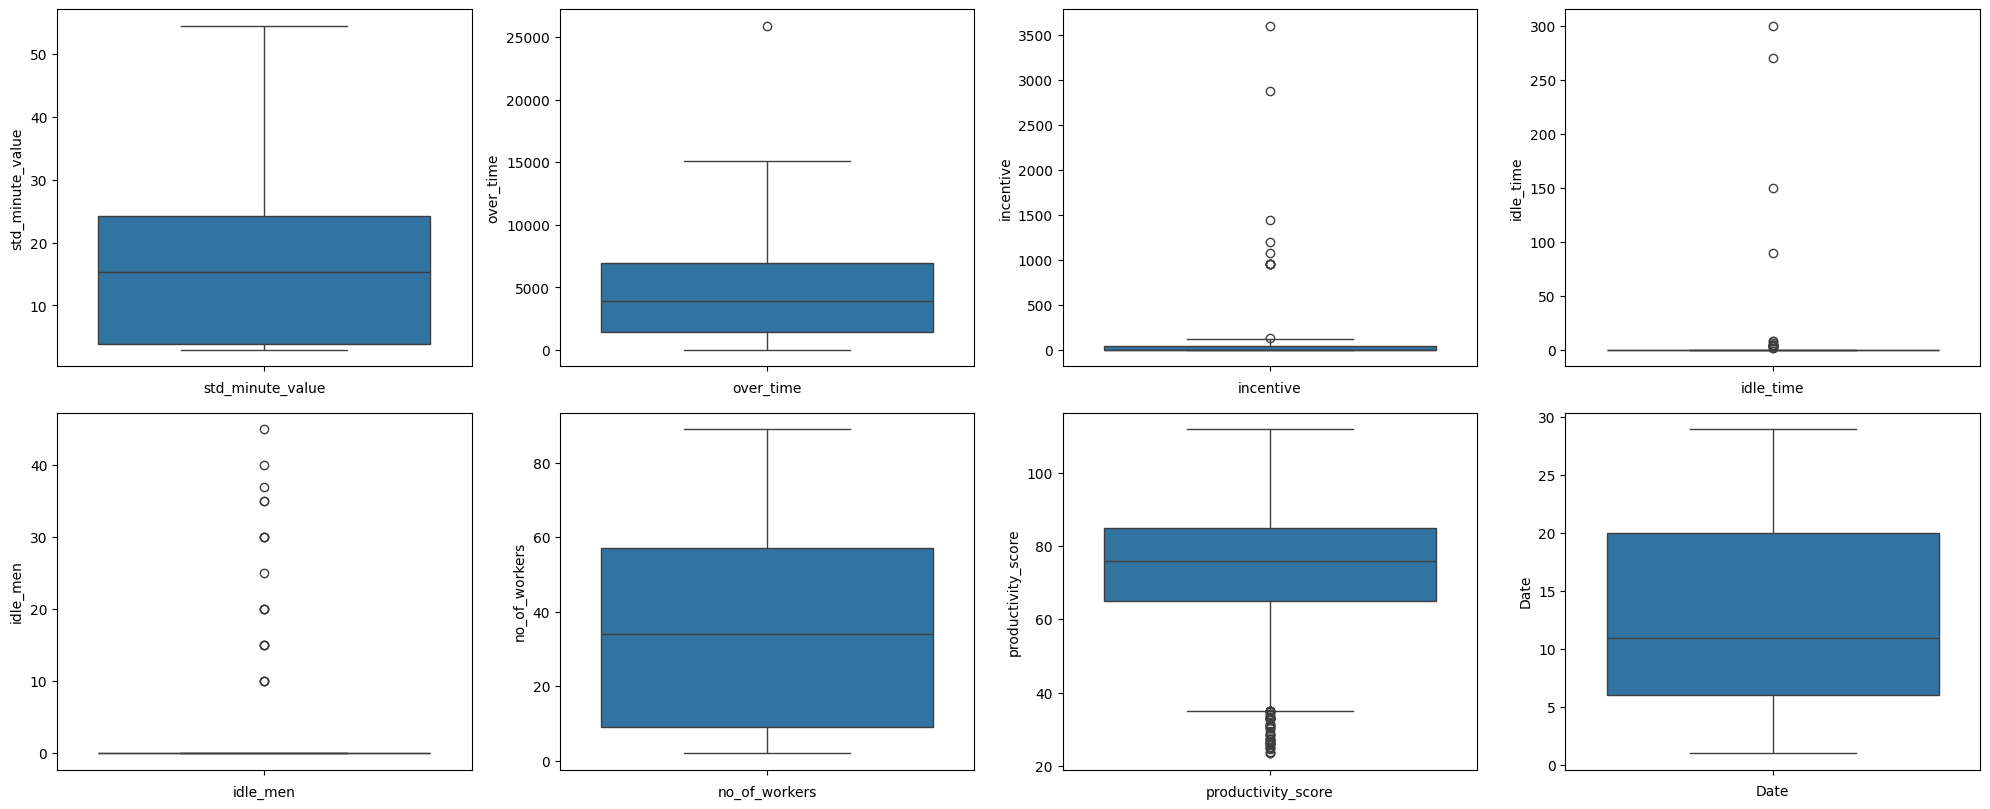

In [ ]:
# Boxplot
fig = plt.figure(figsize=(20, 20))

for i, col in enumerate(num_cols, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(df[col])
    plt.xlabel(col)

plt.tight_layout()
plt.show()

I decided to keep the outliers because removing them would result in a loss of valuable data. Since outliers can sometimes represent significant events or rare occurrences in the dataset, preserving them allows for a more comprehensive analysis and helps ensure that important insights are not overlooked.

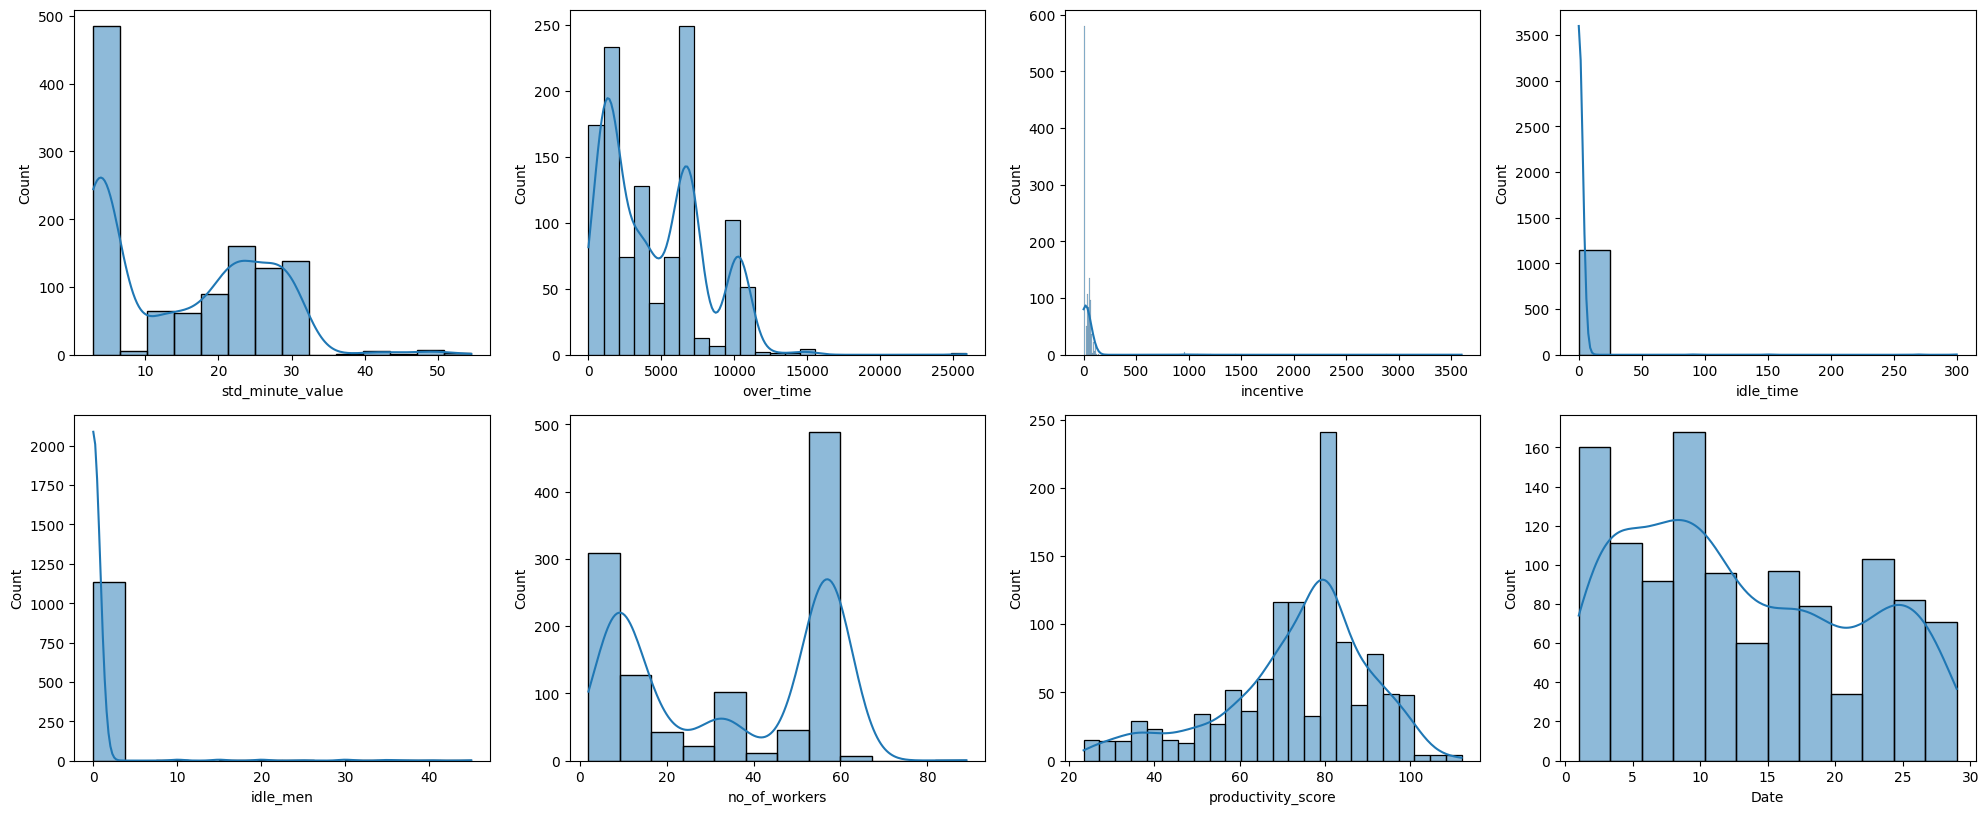

In [ ]:
# Distribution of numerical features - Histogram
fig = plt.figure(figsize=(20, 20))

for i, col in enumerate(num_cols, 1):
    plt.subplot(5, 4, i)
    sns.histplot(df[col], kde=True)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

The distributions of the numerical features indicate that the Standard Minute Value and Over Time features are left-skewed. In contrast, the Incentive, Idle Time, and Idle Men features are heavily peaked at zero. I chose not to handle these columns to avoid losing data. The Number of Workers displays a bimodal pattern, reflecting variability in team sizes, while the Productivity Score peaks around 80, suggesting that many teams perform well. Lastly, the Date distribution shows fluctuations, indicating varying levels of activity throughout the month.

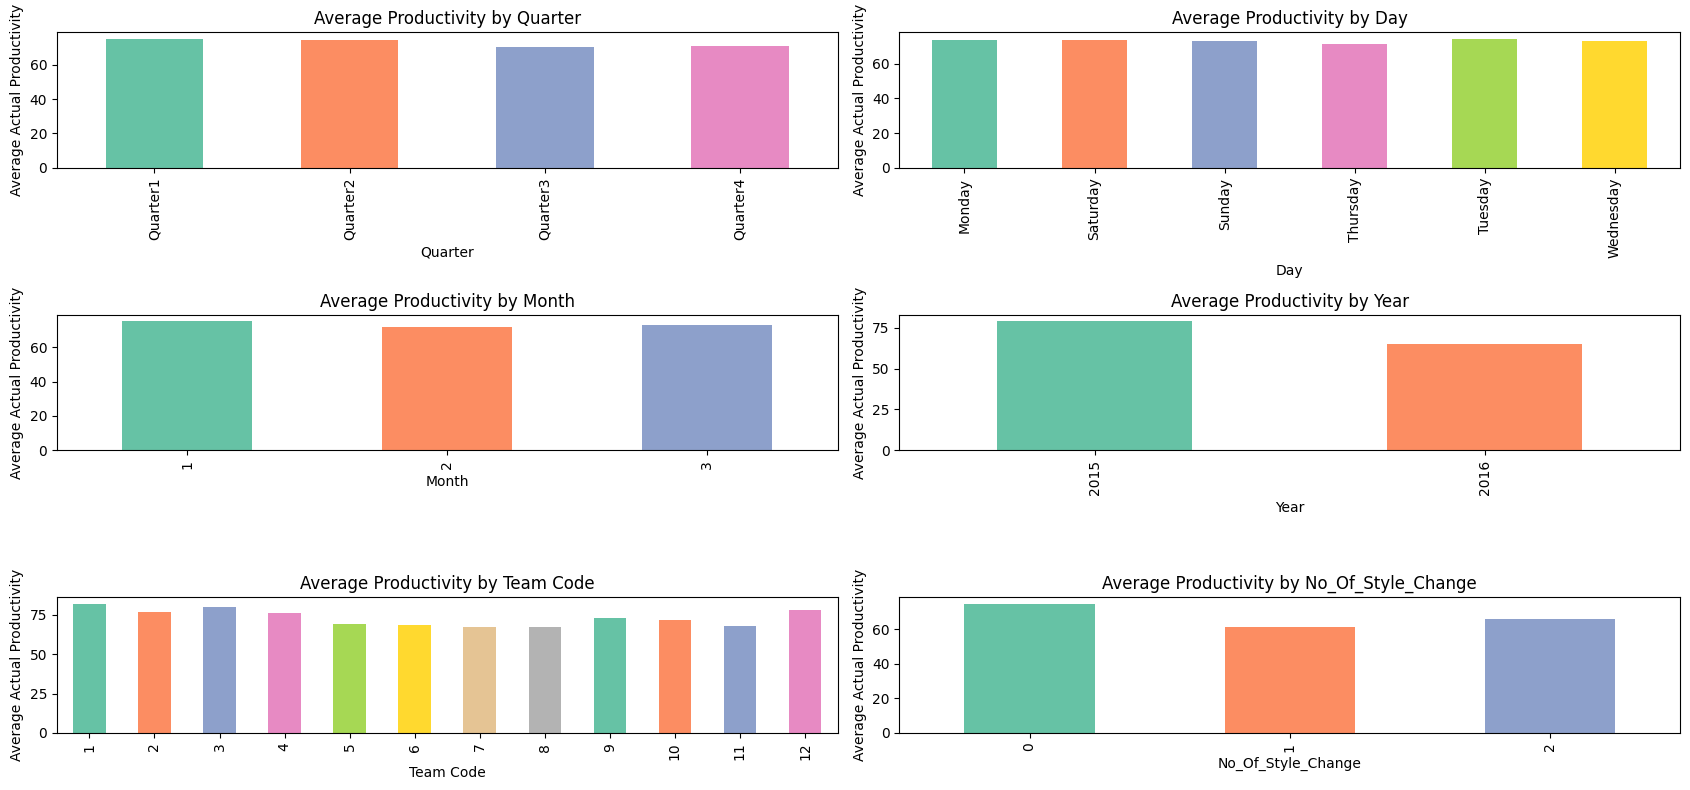

In [ ]:
# Barplot

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(17, 8))

# Flatten the axes array for easier indexing
for i, ax in enumerate(axes.ravel()):
    if i < len(cat_cols):  # Ensure we don't run into an error if cat_cols has fewer than 6 items
        avg_prod = df.groupby(cat_cols[i])['productivity_score'].mean()
        avg_prod.plot.bar(ax=ax, color=sns.color_palette('Set2', n_colors=len(avg_prod)))
        ax.set_title(f"Average Productivity by {cat_cols[i].title()}")
        ax.set_xlabel(cat_cols[i].title())
        ax.set_ylabel("Average Actual Productivity")
    else:
        ax.axis('off')  # Hide any unused subplots

# Adjust layout
fig.tight_layout()
plt.show()

The count plots reveal important insights across various categorical features. In the **quarter** distribution, Quarter 1 has the highest entries, followed by Quarter 2, indicating a concentration of activities in the first half of the year. The **day** plot shows that Sunday and Thursday are the busiest, while Saturday and Monday have lower counts. For **months**, January and February are notably more active than March. In terms of **year**, 2015 has significantly more entries than 2016, suggesting a higher volume of data collection in that year. The **team code** counts are balanced, with Team 8 slightly leading, and the **number of style changes** overwhelmingly reflects no changes, indicating infrequent style alterations. Overall, these patterns offer valuable insights for operational and productivity strategies in the garment industry.

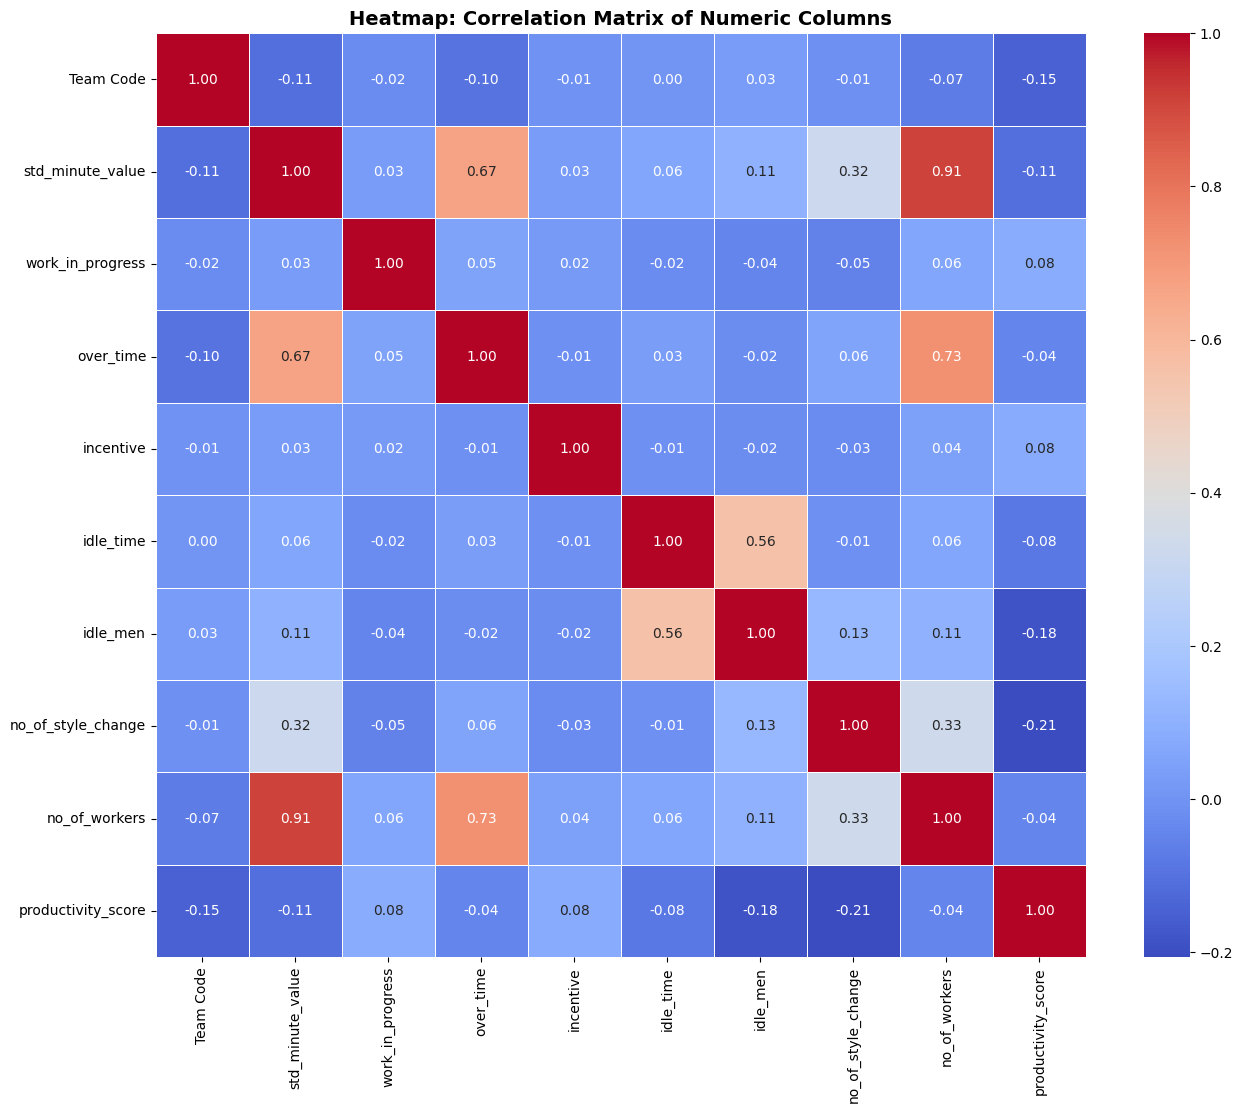

In [ ]:
# Heatmap
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap: Correlation Matrix of Numeric Columns', fontsize=14, fontweight='bold')
plt.show()

From the heapmap, it shows that there are significant relationship among the features in garment dataset. Strong correlation between no_of_workers and std_minute_value (0.91) indicate that task require more time tend to involve larger teams. Negative Correlation such as Team Code and productivity score (-0.15) implies higher team assignment may relate to lower productivity levels

In [ ]:
# delete date month year
df = df.drop(columns=['Date', 'Month', 'Year'])

# **Encoding**

In [ ]:
quarter_map = {'Quarter1': 1, 'Quarter2': 2, 'Quarter3': 3, 'Quarter4': 4}
df['quarter'] = df['quarter'].map(quarter_map)

day_map = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6,
}
df['day'] = df['day'].map(day_map)

Map the unique values in quarter and day columns to their corresponding numerical representations, this mapping method assign numerical values based on the unique categories present in each column.

In [ ]:
encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded_array = encoder.fit_transform(df[['Team Code']])

# Convert to integer type (if needed)
encoded_array = encoded_array.astype(int)

# Get column names
encoded_cols = encoder.get_feature_names_out(['Team Code'])

# Make it a DataFrame
df_encoded = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)

# Combine with original DataFrame
df_final = pd.concat([df.drop(columns=['Team Code']), df_encoded], axis=1)

Then, I performed one-hot encoding for the Team Code because it contains discrete categorical values ranging from 1 to 12. One hot encoding effectively converts these categories into binary columns, which help to ensure the team code are treated as distinct categories, improving model's ability to learn patterns associated with each team.

# **Target Features**

The goal is predicting productivity score each team in garment company.

Target Feature : "productivity_score"

In [ ]:
# Split Target Features
x = df_final.drop(['productivity_score'], axis=1)  # Drop the target column from X
y = df_final['productivity_score']  # Target variable y

In [ ]:
x.head()

,quarter,day,std_minute_value,work_in_progress,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,Team Code_3,Team Code_4,Team Code_5,Team Code_6,Team Code_7,Team Code_8,Team Code_9,Team Code_10,Team Code_11,Team Code_12
0,1,3,26.16,1108.0,7080,98,0.0,0,0,59.0,...,0,0,0,0,0,1,0,0,0,0
1,1,3,3.94,1039.0,960,0,0.0,0,0,8.0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,11.41,968.0,3660,50,0.0,0,0,30.5,...,0,0,0,0,0,0,0,0,1,0
3,1,3,11.41,968.0,3660,50,0.0,0,0,30.5,...,0,0,0,0,0,0,0,0,0,1
4,1,3,25.90,1170.0,1920,50,0.0,0,0,56.0,...,0,0,0,1,0,0,0,0,0,0


Since "productivity_score" is the target variable, it is removed from x and assigned to y for model training.

# **Split Data**

**Step 1 (test_size=0.3):**

70% of the data is used for the train set.

30% of the data is used for the temporary set (x_temp, y_temp).

**Step 2 (test_size=1/3):**

From the 30% temporary data, 1/3 becomes the test set (which is 10% of the total data).

2/3 becomes the validation set (which is 20% of the total data).

So, with these two splits:

70% of the data is used for training.

20% of the data is used for validation.

10% of the data is used for testing.

In [ ]:
# Split into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=1/3, random_state=42)

Next, split the data into training, validation, and testing sets to ensure proper model evaluation. First, 80% of the data is allocated to the training set (x_train, y_train), while the remaining 20% is used as the test set (x_test, y_test). Then, 25% of the training set is further split into a validation set (x_val, y_val), ensuring a well-balanced dataset for effective model training, hyperparameter tuning, and final evaluation.

In [ ]:
numeric_cols = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = x_train.select_dtypes(include=['object']).columns

# **Scaling**

In [ ]:
scaler = StandardScaler()
x_train_scaled_num = scaler.fit_transform(x_train[numeric_cols])
x_val_scaled_num = scaler.transform(x_val[numeric_cols])
x_test_scaled_num = scaler.transform(x_test[numeric_cols])

x_train_scaled = pd.DataFrame(x_train_scaled_num, columns=numeric_cols, index=x_train.index)
x_val_scaled = pd.DataFrame(x_val_scaled_num, columns=numeric_cols, index=x_val.index)
x_test_scaled = pd.DataFrame(x_test_scaled_num, columns=numeric_cols, index=x_test.index)

x_train_scaled = pd.concat([x_train_scaled, x_train[categorical_cols]], axis=1)
x_val_scaled = pd.concat([x_val_scaled, x_val[categorical_cols]], axis=1)
x_test_scaled = pd.concat([x_test_scaled, x_test[categorical_cols]], axis=1)

In this project, I employed StandardScaler to preprocess the input features for the Artificial Neural Network (ANN) aimed at predicting productivity. The decision was based on several key factors:

1. Handling Outliers: The dataset contains various outliers, and using MinMaxScaler could compress the scale of non-outlier data, negatively impacting the model. StandardScaler, which normalizes features based on their mean and standard deviation, is less sensitive to extreme values.

2. Addressing Skewed Distributions: Many features are not uniformly distributed and exhibit skewness. MinMaxScaler assumes a uniform spread, which isn't suitable here, while StandardScaler effectively centers the data around zero and scales it according to its spread.

3. Enhancing Neural Network Stability and Performance: Standardization leads to faster and more reliable convergence for neural networks. By ensuring inputs have a mean of 0 and a standard deviation of 1, each neuron receives data on a consistent scale, resulting in more stable gradient updates during training.

With these considerations, StandardScaler is the optimal choice for scaling in this scenario, promoting robust model performance and efficient training.

# **Building Tensor Dataset**

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train_scaled,y_train)).batch(32).shuffle(10)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_scaled,y_test)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val_scaled,y_val)).batch(32)

In [ ]:
# Print x_train shape
print(x_train_scaled.shape)

(807, 22)


In [ ]:
train_ds

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

# **Baseline Model**

A baseline model is a starting point in a project. It is a simple model that helps us to know how weel basic methods perform.

## *Sequential*

In [ ]:
model = tf.keras.Sequential([
    Dense(128, activation='relu', input_shape=(22,)), # Neuron minimal 2X from input
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

The first model is a Sequential model with three hidden layers. The first layer has 128 neurons, followed by a second layer with 64 neurons, both using ReLU activation to capture complex patterns in the data.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [ ]:
# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

The minimum required number of epochs is 10, but in this case, I used 50 epochs to give the model more time to learn and potentially achieve better performance.

In [ ]:
# Train the model
history = model.fit(x_train_scaled, y_train,
                    validation_data=(x_val_scaled, y_val),
                    epochs=50,
                    batch_size=32,
                    verbose=1)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 5358.6362 - mean_absolute_error: 71.0948 - mean_squared_error: 5358.6362 - val_loss: 4651.6113 - val_mean_absolute_error: 66.2169 - val_mean_squared_error: 4651.6113
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4678.4561 - mean_absolute_error: 65.9596 - mean_squared_error: 4678.4561 - val_loss: 3248.8472 - val_mean_absolute_error: 54.5327 - val_mean_squared_error: 3248.8472
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2986.9148 - mean_absolute_error: 51.5474 - mean_squared_error: 2986.9148 - val_loss: 1464.6555 - val_mean_absolute_error: 35.1155 - val_mean_squared_error: 1464.6555
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1168.5156 - mean_absolute_error: 30.5262 - mean_squared_error: 1168.5156 - val_loss: 415.9604 - val_mean_absolute_error: 17.6726 - val_mean_squared_error: 415.9604
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 357.2380 - mean_absolute_error: 15.6365 - m

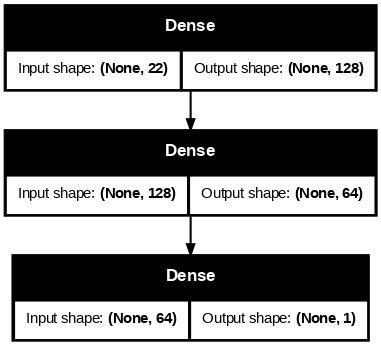

In [ ]:
plot_model(model,show_shapes=True, dpi=75)

In [ ]:
# Prediction
y_pred = model.predict(x_test_scaled)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


### *Evaluate*

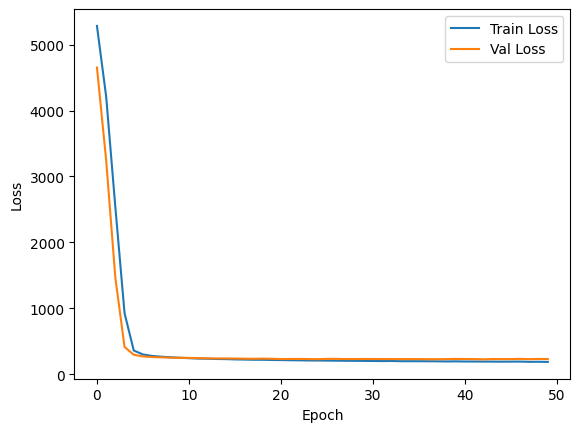

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The loss curve shows that both training and validation loss dropped significantly in the first few epochs and then gradually stabilized, indicating the model learned quickly without overfitting. The small gap between train and validation loss suggests good generalization.  
However, since the loss decreased very rapidly, it might also indicate that the model is too simple for the dataset and may not be capturing more complex patterns.

In [ ]:
# 3 Metric Analysis
R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)

print("R² Score=", R2)
print("Mean Absolute Error=", MAE)
print("Mean Squared Error=", MSE)

R² Score= 0.12921236289162408
Mean Absolute Error= 12.86850448937252
Mean Squared Error= 308.3501299756072


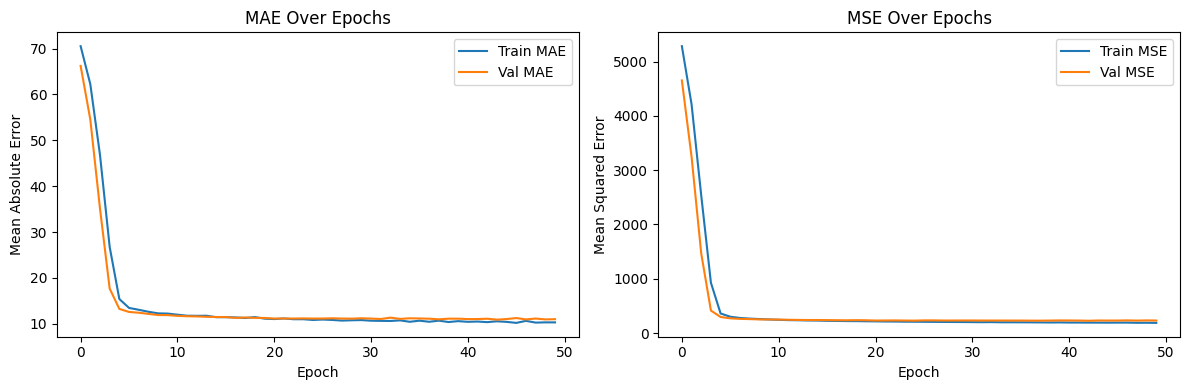

In [ ]:
# Plot Mean Absolute Error (MAE)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE Over Epochs')
plt.legend()

# Plot Mean Squared Error (MSE)
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_squared_error'], label='Train MSE')
plt.plot(history.history['val_mean_squared_error'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

The model learned quickly, as shown by the loss curves stabilizing without overfitting. However, the final metrics are
1. R² = 0.129,
2. MAE = 12.87, and
3. MSE = 308.35

indicate that the model's predictive power is low, explaining only 12.9% of the variance. This suggests the model is too simple for the dataset, and improvements are needed. High MAE and MSE value also indicate that the still need more modification to predict accurately.

## *Functional API*

In [ ]:
from tensorflow.keras.layers import Input

inputs = Input(shape=(x_train_scaled.shape[1],))

In [ ]:
x = Dense(128, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='linear')(x)

The second model is built using the Functional API with three layers. The first layer has 128 neurons with ReLU activation, followed by a second layer with 64 neurons, also using ReLU activation to capture more complex patterns.

In [ ]:
model_1 = Model(inputs=inputs, outputs=outputs)

In [ ]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [ ]:
# Model Summary
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

The minimum required number of epochs in this model is also 10, but in this case, I also used 50 epochs to give the model more time to learn and potentially achieve better performance.

In [ ]:
# Train the model
history = model_1.fit(x_train_scaled, y_train,
                    validation_data=(x_val_scaled, y_val),
                    epochs=50,
                    batch_size=32,
                    verbose=1)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5449.6519 - mean_absolute_error: 71.6416 - mean_squared_error: 5449.6519 - val_loss: 4719.4854 - val_mean_absolute_error: 66.7400 - val_mean_squared_error: 4719.4854
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4672.2324 - mean_absolute_error: 66.0836 - mean_squared_error: 4672.2324 - val_loss: 3360.1025 - val_mean_absolute_error: 55.5893 - val_mean_squared_error: 3360.1025
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2949.0913 - mean_absolute_error: 51.2472 - mean_squared_error: 2949.0913 - val_loss: 1486.9247 - val_mean_absolute_error: 35.4299 - val_mean_squared_error: 1486.9247
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1160.7073 - mean_absolute_error: 30.6357 - mean_squared_error: 1160.7073 - val_loss: 388.8639 - val_mean_absolute_error: 16.6818 - val_mean_squared_error: 388.8639
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 383.6802 - mean_absolute_error: 15.9054 - mean_

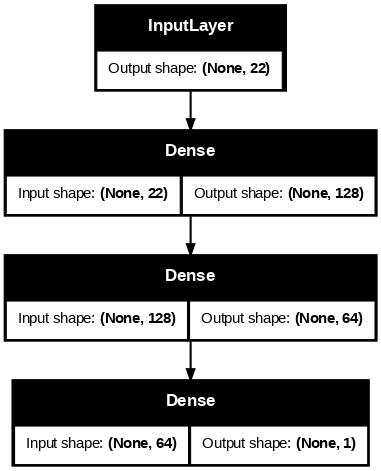

In [ ]:
plot_model(model_1, show_shapes=True, dpi=75)

In [ ]:
y_pred = model_1.predict(x_test_scaled)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


### *Evaluate*

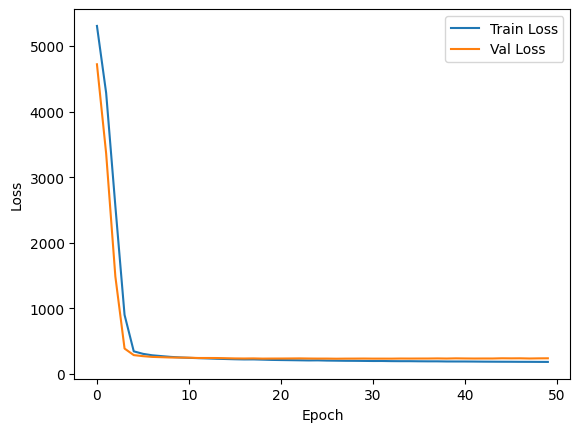

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The loss curve for the functional model shows that both training and validation loss drop significantly, just like in the sequential model. The smaller gap between the two suggests better generalization. However, the quick decrease in the plot indicates that the model might be too simple for the data, which could mean it's not capturing all the necessary details.

In [ ]:
R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)

print("R² Score=", R2)
print("Mean Absolute Error=", MAE)
print("Mean Squared Error=", MSE)

R² Score= 0.10655987020032043
Mean Absolute Error= 13.075829557353057
Mean Squared Error= 316.3714876154902


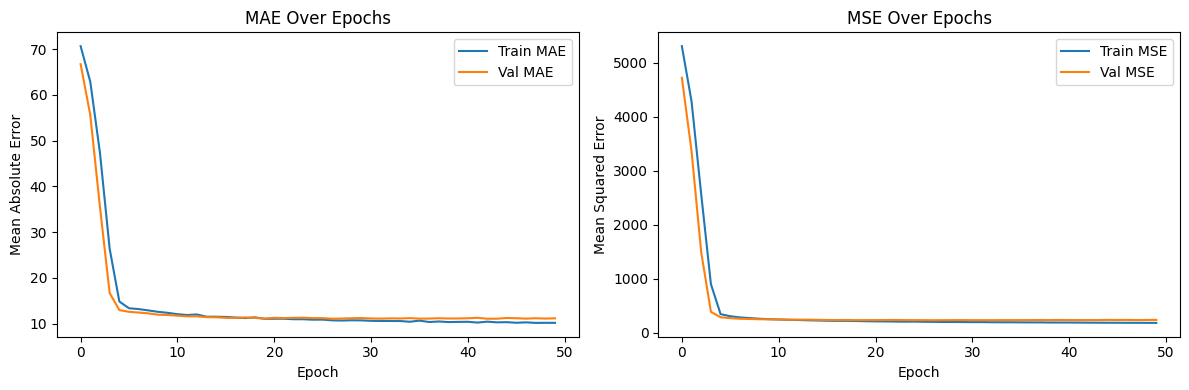

In [ ]:
# Plot Mean Absolute Error (MAE)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE Over Epochs')
plt.legend()

# Plot Mean Squared Error (MSE)
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_squared_error'], label='Train MSE')
plt.plot(history.history['val_mean_squared_error'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

The Functional API model also learned quickly as it shown by the plot of loss curve stable and not overfitting. but the statistical result is
1. R² = 0.106,
2. MAE = 13.07, and
3. MSE = 316.37

which means the model’s predictive capability is low, with an R² score of 0.106, indicating that it explains only 10.6% of the variance in the data. The high values of MSE and MAE further indicate that the model struggles to provide accurate predictions, as it has a substantial average error of approximately 13.07 units.

## **Comparison Both Baseline Model**

Both the Sequential and Functional API models displayed similar learning curves with a rapid reduction in loss, indicating that they both learned from the training data quickly. However, the low values of R², high values of MAE, and MSE reveal that both models struggle to accurately predict productivity scores based on the data. Overall, the statistical results show that the Sequential model performs slightly better than the Functional API model, yielding more accurate predictions with lower error metrics.

In conclusion, both models appear to be too simplistic for the dataset, making it challenging to effectively predict productivity scores.

# **Modify Model**

Next, I modified the ANN model to achieve better performance compared to the baseline model by adding Dropout for regularization to reduce overfitting, and BatchNormalization to stabilize and speed up the training process, resulting in more efficient learning and improved generalization.

## *Sequential*

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

In [ ]:
model_seq = Sequential([
    Dense(128, activation='elu', kernel_regularizer=l2(0.001), input_shape=(22,)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='elu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='elu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='elu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),

    Dense(1, activation='linear')
])

To enhance the performance of the sequential model, I made several modifications. I replaced the activation function with the Exponential Linear Unit (ELU) for each layer. ELU is advantageous because it helps mitigate the risk of vanishing gradients and avoids the "dying ReLU" problem, where neurons become inactive during training. Unlike ReLU, ELU allows for negative values, maintaining a mean output closer to zero, which supports better gradient flow and faster convergence.

Additionally, I implemented L2 regularization with a strength of 0.001 to help prevent overfitting by penalizing large weights. Batch normalization is retained after each dense layer to stabilize learning and improve convergence further. Dropout layers are included to randomly disable a portion of neurons during training, further reducing the likelihood of overfitting. After experimenting with both activation functions, I found that using ELU yielded better results, with lower loss and improved accuracy during training and validation. Consequently, this modified structure aims to enhance the overall performance of the model while effectively addressing potential overfitting issues.

In [ ]:
model_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error']
)

Also, using a learning rate of 0.001 for the optimizer helps to control the step size during training, allowing the model to converge more smoothly and efficiently.

In [ ]:
# Model Summary
model_seq.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,865 (81.50 KB)

 Trainable params: 20,225 (79.00 KB)

 Non-trainable params: 640 (2.50 KB)

Then, I trained the model with EarlyStopping (patience = 10), which halts training if the validation loss doesn’t improve for 10 consecutive epochs, and used 250 epochs to give the model enough time to converge while preventing overfitting.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model_seq.fit(x_train_scaled, y_train,
                    validation_data=(x_val_scaled, y_val),
                    epochs=250,
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 5724.2617 - mean_absolute_error: 73.7766 - mean_squared_error: 5724.0103 - val_loss: 5443.7822 - val_mean_absolute_error: 72.0558 - val_mean_squared_error: 5443.5308
Epoch 2/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5467.1777 - mean_absolute_error: 72.0414 - mean_squared_error: 5466.9258 - val_loss: 5380.5049 - val_mean_absolute_error: 71.7140 - val_mean_squared_error: 5380.2534
Epoch 3/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5511.7173 - mean_absolute_error: 72.4151 - mean_squared_error: 5511.4653 - val_loss: 5300.6914 - val_mean_absolute_error: 71.2235 - val_mean_squared_error: 5300.4380
Epoch 4/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5407.8628 - mean_absolute_error: 71.7485 - mean_squared_error: 5407.6099 - val_loss: 5169.8657 - val_mean_absolute_error: 70.3036 - val_mean_squared_error: 5169.6118
Epoch 5/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5281.1406 - mean_absolute_error: 70.6

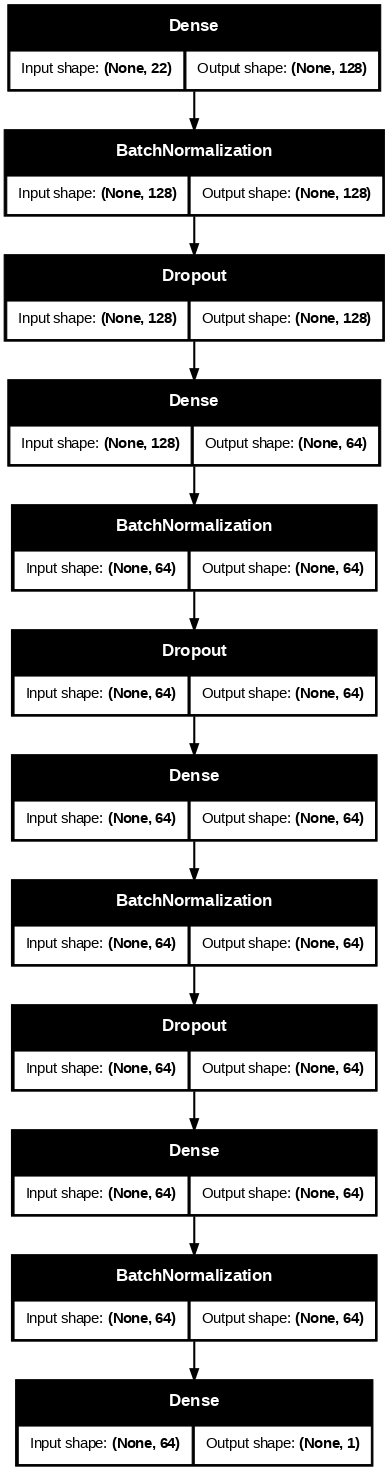

In [ ]:
plot_model(model_seq,show_shapes=True, dpi=75)

In [ ]:
# Prediction
y_pred = model_seq.predict(x_test_scaled)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


### *Evaluate*

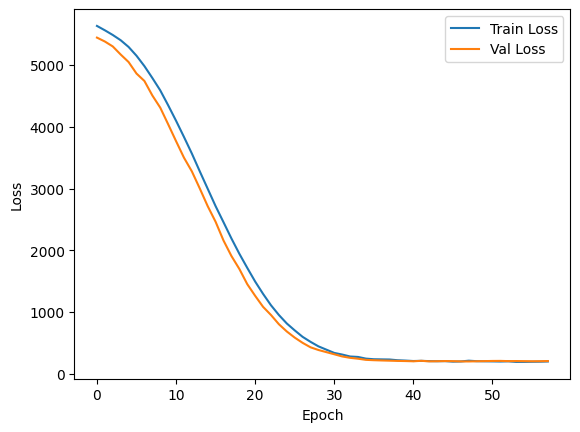

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

This loss curve plot is much improved, as the model trains more effectively. The loss starts to decline at around epoch 30 and stabilizes between epochs 40 and 50, indicating that the model is converging. The closeness of the training and validation loss suggests that the model is generalizing well to the validation data without significant overfitting. Overall, this behavior reflects that the adjustments made to the model such as using ELU activation and incorporating L2 regularization are having a positive impact on training dynamics and model performance.

In [ ]:
R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)

print("R² Score=", R2)
print("Mean Absolute Error=", MAE)
print("Mean Squared Error=", MSE)

R² Score= 0.25563211127907237
Mean Absolute Error= 11.70159676440009
Mean Squared Error= 263.58428330350785


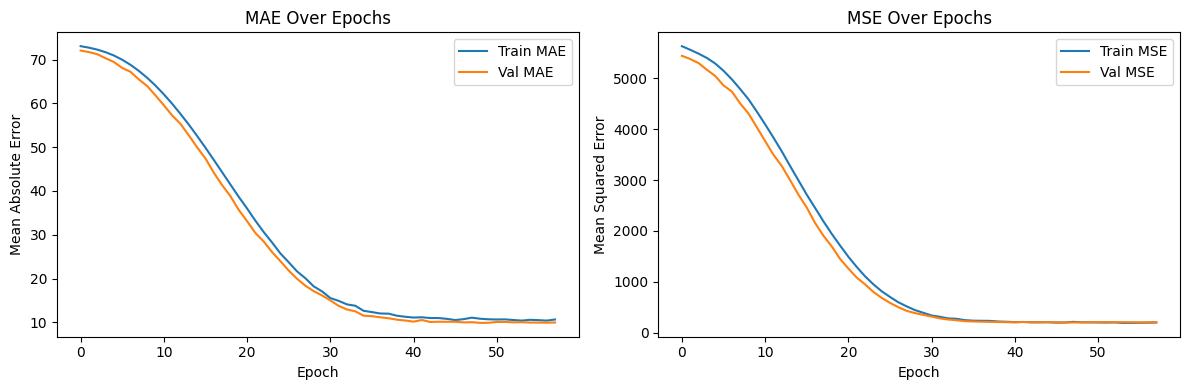

In [ ]:
# Plot Mean Absolute Error (MAE)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE Over Epochs')
plt.legend()

# Plot Mean Squared Error (MSE)
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_squared_error'], label='Train MSE')
plt.plot(history.history['val_mean_squared_error'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

The modified Sequential model shows a relatively low R² score of 0.25, meaning it only explains 25% of the variance in the target variable. Additionally, the high MAE (11.7) and MSE (263.58) indicate that the model’s predictions are not very close to the actual values. A low R² combined with high error values suggests that the model struggles to capture the underlying patterns in the data and may not be complex enough or is missing important features needed for accurate prediction.

## *Functional API*

In [ ]:
from tensorflow.keras.layers import Input

inputs = Input(shape=(x_train_scaled.shape[1],))

In [ ]:
# Input layer
inputs = Input(shape=(22,))

# Hidden layers
x = Dense(128, activation='elu', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='elu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='elu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='elu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)

# Output layer
outputs = Dense(1, activation='linear')(x)

# Create model
model_func = Model(inputs=inputs, outputs=outputs)

This uses a Functional API model with a series of Dense layers and ReLU activation functions in the hidden layers to learn non-linear patterns. The model starts with an input layer that accepts 25 features. Each hidden layer uses BatchNormalization to stabilize training and Dropout (0.3 rate) to prevent overfitting. The architecture has four hidden layers with 128, 64, 64, and 64 units, respectively, and concludes with a linear activation function in the output layer, making it suitable for regression tasks.

In [ ]:
model_func.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error']
)

Additionally, the model is compiled with an Adam optimizer using a learning rate of 0.001, which helps to control the step size during training, ensuring efficient convergence.

In [ ]:
# Show model summary
model_func.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,865 (81.50 KB)

 Trainable params: 20,225 (79.00 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model_func.fit(x_train_scaled, y_train,
                    validation_data=(x_val_scaled, y_val),
                    epochs=250,
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 5665.9287 - mean_absolute_error: 73.1542 - mean_squared_error: 5665.6777 - val_loss: 5429.6685 - val_mean_absolute_error: 71.9804 - val_mean_squared_error: 5429.4170
Epoch 2/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5512.6455 - mean_absolute_error: 72.4187 - mean_squared_error: 5512.3931 - val_loss: 5365.8384 - val_mean_absolute_error: 71.6263 - val_mean_squared_error: 5365.5859
Epoch 3/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5658.9316 - mean_absolute_error: 73.4071 - mean_squared_error: 5658.6797 - val_loss: 5251.0713 - val_mean_absolute_error: 70.8818 - val_mean_squared_error: 5250.8184
Epoch 4/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5446.0249 - mean_absolute_error: 71.9690 - mean_squared_error: 5445.7710 - val_loss: 5132.5806 - val_mean_absolute_error: 70.0485 - val_mean_squared_error: 5132.3271
Epoch 5/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5371.6499 - mean_absolute_error: 71.5

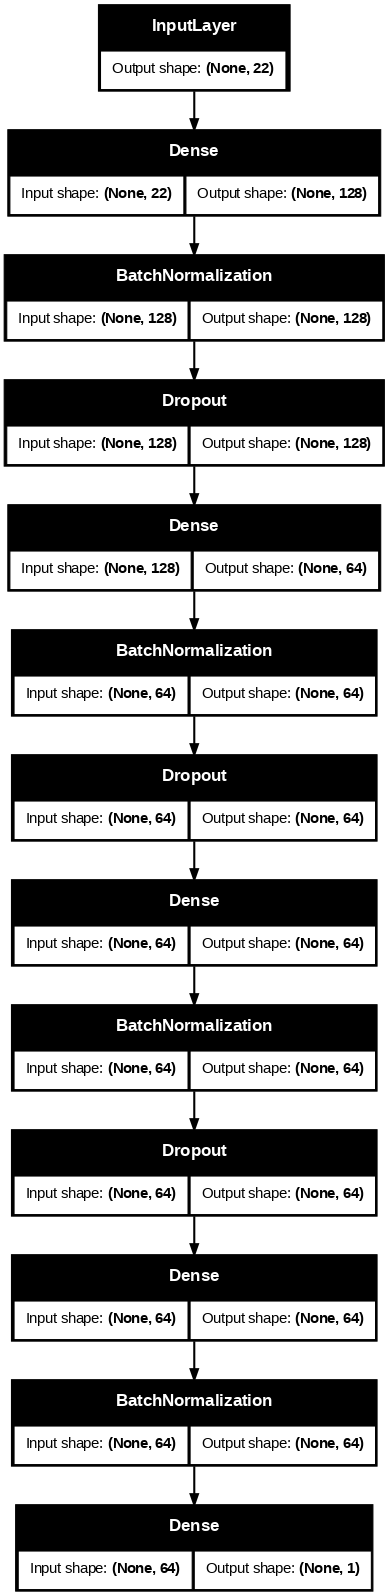

In [ ]:
plot_model(model_func, show_shapes=True, dpi=75)

In [ ]:
y_pred = model_func.predict(x_test_scaled)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


### *Evaluate*

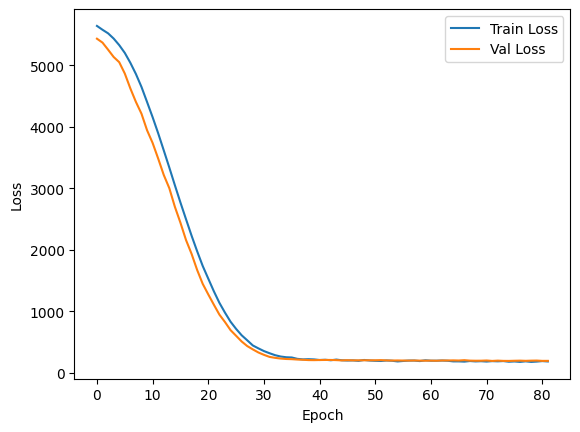

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Based on the plot, the loss curve for both training and validation in modified functional API model shows a consistent decrease throughout epochs, which means the model is effectively learning from the training data while generating well with the validation dataset. The small gap between the two curves suggests that the model is not overfitting, and it can be concluded that it has converged by epoch 60.

In [ ]:
R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)

print("R² Score=", R2)
print("Mean Absolute Error=", MAE)
print("Mean Squared Error=", MSE)

R² Score= 0.30773368610369567
Mean Absolute Error= 11.077980034795301
Mean Squared Error= 245.13486270487005


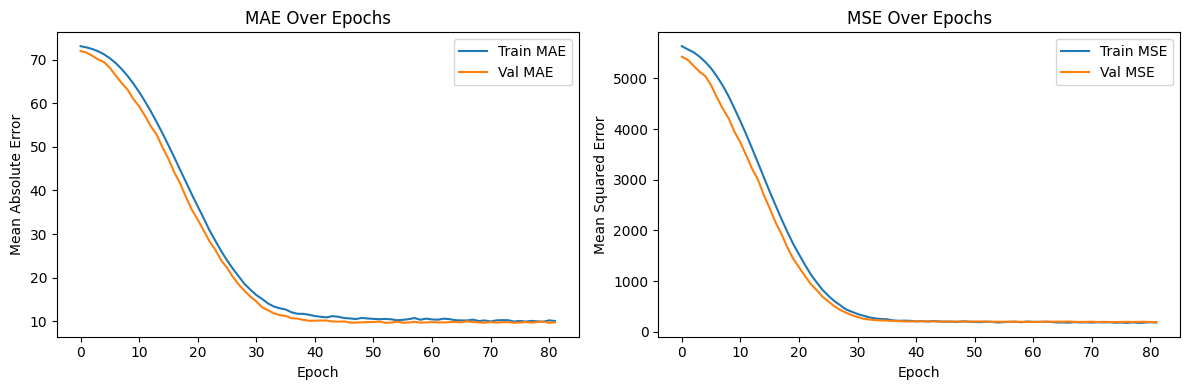

In [ ]:
# Plot Mean Absolute Error (MAE)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE Over Epochs')
plt.legend()

# Plot Mean Squared Error (MSE)
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_squared_error'], label='Train MSE')
plt.plot(history.history['val_mean_squared_error'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

The statistical results for modified functional API model shows a low values of R² (0.3), and high values of MAE (11.07) and MSE (245.13). This means that the model's predictivity is limited because its only 30% of the variance in the data.

But based on the curve plots, both MSE and MAE decrease consistently throughout epochs, which means the model learn effectively without overfitting.

## **Comparison Both Modified Model**

Both modified models shows that the loss curve decrease consistently, we can indicate that the models are learning effectively from the dataset and showing no overfitting. However, based on the statistical results such as values of R², MAE, and MSE, suggest that the model are not yet performing optimal predict for productivity score, as both values for R² is low, and high values of MAE and MSE.

Additionally, when we compare both modified model, the functional API model show better performance than the sequential model.

# **Conclusion**

Based on the goal to estimate the productivity score for each team in a garment factory, I went through a comprehensive process involving data cleaning, visualization, preprocessing, model building, and evaluation. At first, both the baseline models (sequential and functional API) showed they learned fase\t because the loss curve were decreased in small epochs, but there is no indicate overfitting. While this was quite good, the results weren't good based on the statistical results with low R² and high MAE and MSE.

After modifying the models by adding batch normalization, dropout, change ReLU into ELU activation, and apply L2 regulation, I notice a better performance. The loss curve for both models are decrease consistently without any overfitting, which means the models were learning effectively. They even converged around epochs 50/60.

However, all statistical results still shows low values of R² and high values for both MAE and MSE, which means need to keep improving. This also might because of the dataset has its own challenges, such as quality issues or insufficient diversity in samples.

---